In [18]:
import sys
sys.path.append('../')
from src.learning.model import MLP

In [87]:
import torch
import torch.nn as nn

class ConvexFunctionNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, positive_weights=True, weight_min=1e-8):
        """
        Initialize the neural network.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        :param positive_weights: If True, constraints weights to be positive.
        """
        super(ConvexFunctionNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.positive_weights = positive_weights
        self.weight_min = weight_min

        # Create the network architecture
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_layers:
            linear = nn.Linear(prev_dim, hidden_dim)
            if positive_weights:
                # Constraint weights to be positive
                with torch.no_grad():
                    linear.weight.clamp_(min=0)
            layers.append(linear)
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer
        output_layer = nn.Linear(prev_dim, output_dim)
        if positive_weights:
            # Constraint weights to be positive
            with torch.no_grad():
                output_layer.weight.clamp_(min=0)
        layers.append(output_layer)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def clamp_weights(self):
        """
        Ensure that the weights remain positive after training updates.
        """
        if self.positive_weights:
            for layer in self.layers:
                if isinstance(layer, nn.Linear):
                    with torch.no_grad():
                        layer.weight.clamp_(min=self.weight_min)
    
    def extra_repr(self):
        """
        Extra representation of the module to display its unique properties.
        """
        return f'input_dim={self.input_dim}, output_dim={self.output_dim}, ' \
               f'hidden_layers={self.hidden_layers}, positive_weights={self.positive_weights}'

# Example usage
model = ConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True)
print(model)


ConvexFunctionNN(
  input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)


In [88]:
class EnhancedConvexFunctionNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, positive_weights=True, weight_min=1e-8):
        """
        Initialize the enhanced neural network.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        :param positive_weights: If True, constraints weights to be positive.
        """
        super(EnhancedConvexFunctionNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.positive_weights = positive_weights
        self.weight_min = weight_min

        # Main layers from previous hidden layer
        self.main_layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            linear = nn.Linear(prev_dim, hidden_dim)
            self.main_layers.append(linear)
            prev_dim = hidden_dim

        # Additional layers from the original input
        self.additional_layers = nn.ModuleList()
        for hidden_dim in hidden_layers[1:]:  # Skip first layer as it directly connects to input
            linear = nn.Linear(input_dim, hidden_dim)
            self.additional_layers.append(linear)

        # Output layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        # Applying layers
        for i, main_layer in enumerate(self.main_layers):
            x_main = main_layer(x if i == 0 else output)

            # Apply additional layer if not the first hidden layer
            if i > 0:
                x_additional = self.additional_layers[i-1](x)
                output = nn.ReLU()(x_main + x_additional)
            else:
                output = nn.ReLU()(x_main)

        return self.output_layer(output)

    def clamp_weights(self):
        """
        Ensure that the weights remain positive after training updates.
        """
        if self.positive_weights:
            for layer in self.main_layers:
                with torch.no_grad():
                    layer.weight.clamp_(min=self.weight_min)
            for layer in self.additional_layers:
                with torch.no_grad():
                    layer.weight.clamp_(min=self.weight_min)
    
    def extra_repr(self):
        """
        Extra representation of the module to display its unique properties.
        """
        return f'input_dim={self.input_dim}, output_dim={self.output_dim}, ' \
               f'hidden_layers={self.hidden_layers}, positive_weights={self.positive_weights}'

# Example usage
enhanced_model = EnhancedConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True)
print(enhanced_model)


EnhancedConvexFunctionNN(
  input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True
  (main_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
  )
  (additional_layers): ModuleList(
    (0): Linear(in_features=10, out_features=30, bias=True)
  )
  (output_layer): Linear(in_features=30, out_features=5, bias=True)
)


In [138]:
class ModifiedEnhancedConvexFunctionNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        """
        Initialize the modified neural network.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        """
        super(ModifiedEnhancedConvexFunctionNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers

        # Main layers from previous hidden layer
        self.main_layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            linear = nn.Linear(prev_dim, hidden_dim)
            if prev_dim != input_dim:  # Apply positivity constraint only to layers after the first
                with torch.no_grad():
                    linear.weight.clamp_(min=0)
            self.main_layers.append(linear)
            prev_dim = hidden_dim

        # Additional layers from the original input
        self.additional_layers = nn.ModuleList()
        for hidden_dim in hidden_layers[1:]:  # Skip first layer as it directly connects to input
            linear = nn.Linear(input_dim, hidden_dim)
            with torch.no_grad():
                linear.weight.clamp_(min=0)
            self.additional_layers.append(linear)

        # Output layer
        self.output_layer = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        for i, main_layer in enumerate(self.main_layers):
            x_main = main_layer(x if i == 0 else output)

            # Apply additional layer if not the first hidden layer
            if i > 0:
                x_additional = self.additional_layers[i-1](x)
                output = nn.ReLU()(x_main + x_additional)
            else:
                output = nn.ReLU()(x_main)

        return self.output_layer(output)
    
    def clamp_weights(self):
        """
        Ensure that the weights remain positive after training updates, except for the first layer.
        """
        for i, layer in enumerate(self.main_layers):
            if i > 0 and isinstance(layer, nn.Linear):  # Skip the first layer
                with torch.no_grad():
                    layer.weight.clamp_(min=0)
            if i < len(self.additional_layers) and isinstance(self.additional_layers[i], nn.Linear):
                with torch.no_grad():
                    self.additional_layers[i].weight.clamp_(min=0)

# Example usage
modified_model = ModifiedEnhancedConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30])
print(modified_model)


ModifiedEnhancedConvexFunctionNN(
  (main_layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
  )
  (additional_layers): ModuleList(
    (0): Linear(in_features=10, out_features=30, bias=True)
  )
  (output_layer): Linear(in_features=30, out_features=5, bias=True)
)


In [89]:
def positive_uniform_init(layer):
    """
    Initialize the weights of the given layer with positive values.
    """
    if isinstance(layer, nn.Linear):
        nn.init.uniform_(layer.weight, 0.01, 0.1)  # Initialize with small positive values
        nn.init.uniform_(layer.bias, 0.01, 0.1)

class PositiveInitConvexFunctionNN(ConvexFunctionNN):
    def __init__(self, input_dim, output_dim, hidden_layers, positive_weights=True):
        """
        Initialize the neural network with positive weights.
        """
        super(PositiveInitConvexFunctionNN, self).__init__(input_dim, output_dim, hidden_layers, positive_weights)
        self.apply(positive_uniform_init)

class PositiveInitEnhancedConvexFunctionNN(EnhancedConvexFunctionNN):
    def __init__(self, input_dim, output_dim, hidden_layers, positive_weights=True):
        """
        Initialize the enhanced neural network with positive weights.
        """
        super(PositiveInitEnhancedConvexFunctionNN, self).__init__(input_dim, output_dim, hidden_layers, positive_weights)
        self.apply(positive_uniform_init)

# Example usage
positive_init_convex_model = PositiveInitConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True)
positive_init_enhanced_convex_model = PositiveInitEnhancedConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True)

# Displaying the initialized weights for verification
print("Weights of the first layer in PositiveInitConvexFunctionNN:")
print(positive_init_convex_model.layers[0].weight)
print("\nWeights of the first layer in PositiveInitEnhancedConvexFunctionNN:")
print(positive_init_enhanced_convex_model.main_layers[0].weight)


Weights of the first layer in PositiveInitConvexFunctionNN:
Parameter containing:
tensor([[0.0648, 0.0991, 0.0313, 0.0201, 0.0259, 0.0472, 0.0208, 0.0236, 0.0290,
         0.0471],
        [0.0153, 0.0119, 0.0327, 0.0725, 0.0563, 0.0797, 0.0811, 0.0635, 0.0326,
         0.0713],
        [0.0944, 0.0198, 0.0916, 0.0115, 0.0499, 0.0183, 0.0448, 0.0779, 0.0217,
         0.0245],
        [0.0994, 0.0685, 0.0795, 0.0448, 0.0935, 0.0120, 0.0951, 0.0414, 0.0683,
         0.0780],
        [0.0664, 0.0756, 0.0264, 0.0207, 0.0580, 0.0883, 0.0722, 0.0194, 0.0551,
         0.0103],
        [0.0804, 0.0429, 0.0755, 0.0922, 0.0731, 0.0825, 0.0681, 0.0220, 0.0133,
         0.0693],
        [0.0758, 0.0184, 0.0110, 0.0513, 0.0286, 0.0639, 0.0862, 0.0382, 0.0927,
         0.0959],
        [0.0818, 0.0978, 0.0804, 0.0590, 0.0543, 0.0168, 0.0588, 0.0454, 0.0958,
         0.0211],
        [0.0467, 0.0133, 0.0600, 0.0575, 0.0364, 0.0159, 0.0483, 0.0541, 0.0991,
         0.0589],
        [0.0601, 0.0162, 0.

In [94]:
# Defining the BarrierConvexFunctionNN class
class BarrierConvexFunctionNN(ConvexFunctionNN):
    def __init__(self, input_dim, output_dim, hidden_layers, positive_weights=True, barrier_strength=1e-4):
        """
        Initialize the neural network with a barrier function for positive weights.

        :param input_dim: Number of input dimensions.
        :param output_dim: Number of output dimensions.
        :param hidden_layers: List containing the number of neurons in each hidden layer.
        :param positive_weights: If True, constraints weights to be positive.
        :param barrier_strength: Strength of the barrier term in the loss function.
        """
        super(BarrierConvexFunctionNN, self).__init__(input_dim, output_dim, hidden_layers, positive_weights)
        self.apply(positive_uniform_init)
        self.barrier_strength = barrier_strength

    def forward(self, x):
        return super(BarrierConvexFunctionNN, self).forward(x), self.get_all_weights()

    def get_all_weights(self):
        """
        Get all the weights from the linear layers of the model.
        """
        all_weights = []
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                all_weights.append(layer.weight)
        return all_weights

    def barrier_loss(self):
        """
        Calculate the barrier loss for all weights.
        """
        loss = 0.0
        for weights in self.get_all_weights():
            loss += -torch.sum(weights * torch.log(weights.clamp(min=1e-10)))
        return self.barrier_strength * loss

# Example usage
barrier_model = BarrierConvexFunctionNN(input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True)

# Display the modified model
print(barrier_model)

BarrierConvexFunctionNN(
  input_dim=10, output_dim=5, hidden_layers=[20, 30], positive_weights=True
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)


In [128]:
def convex_function(x):
    return 1 * (x-2) **4 + x ** 2 + 2 * x + 1 - np.log(x + 0.1) * 10

def convex_function_derivative(x):
    return 1 * 4 * (x-2) ** 3 + 2 * x + 2 - 1 / (x + 0.1) * 10 

In [148]:
# sample x values from -10 to 10 randomly
sample_size = 100
x_values = np.random.uniform(0, 5, size=sample_size)
noise = np.random.normal(0, 3.0, size=sample_size)

y_values = convex_function(x_values) + noise
x_tensor = torch.tensor(x_values.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y_values.reshape(-1, 1), dtype=torch.float32)

# Creating the models
hidden_layers = [10, 20, 10]

mlp_model = MLP(input_dim=1, output_dim=1, hidden_layers=hidden_layers, dropout_rate=0.0)

convex_nn_model = BarrierConvexFunctionNN(input_dim=1, output_dim=1, hidden_layers=hidden_layers, positive_weights=True)

enhanced_convex_nn_model = ModifiedEnhancedConvexFunctionNN(input_dim=1, output_dim=1, hidden_layers=hidden_layers)

# Training parameters
epochs = 1000
learning_rate = 0.01

# Loss function and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
optimizer_convex = torch.optim.Adam(convex_nn_model.parameters(), lr=learning_rate)
optimizer_enhanced_convex = torch.optim.Adam(enhanced_convex_nn_model.parameters(), lr=learning_rate)

# Training loop for all models
for epoch in range(epochs):
    # Train MLP
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_tensor)
    loss_mlp = criterion(outputs_mlp, y_tensor)
    loss_mlp.backward()
    optimizer_mlp.step()

    # Train ConvexFunctionNN
    optimizer_convex.zero_grad()
    output, weights = convex_nn_model(x_tensor)
    primary_loss = criterion(output, y_tensor)  # your primary loss function
    barrier_loss = convex_nn_model.barrier_loss()
    total_loss = primary_loss + barrier_loss
    total_loss.backward()
    optimizer_convex.step()

    # Train EnhancedConvexFunctionNN
    optimizer_enhanced_convex.zero_grad()
    outputs_enhanced_convex = enhanced_convex_nn_model(x_tensor)
    loss_enhanced_convex = criterion(outputs_enhanced_convex, y_tensor)
    loss_enhanced_convex.backward()
    optimizer_enhanced_convex.step()
    enhanced_convex_nn_model.clamp_weights()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}], MLP Loss: {loss_mlp.item():.4f}, "
              f"Convex Loss: {loss_convex.item():.4f}, "
              f"Enhanced Convex Loss: {loss_enhanced_convex.item():.4f}")



Epoch [0/1000], MLP Loss: 1104.3584, Convex Loss: 413.7339, Enhanced Convex Loss: 1198.0771
Epoch [100/1000], MLP Loss: 301.4633, Convex Loss: 413.7339, Enhanced Convex Loss: 240.8711
Epoch [200/1000], MLP Loss: 12.5780, Convex Loss: 413.7339, Enhanced Convex Loss: 36.2988
Epoch [300/1000], MLP Loss: 8.8698, Convex Loss: 413.7339, Enhanced Convex Loss: 11.5248
Epoch [400/1000], MLP Loss: 8.6145, Convex Loss: 413.7339, Enhanced Convex Loss: 10.1366
Epoch [500/1000], MLP Loss: 8.5254, Convex Loss: 413.7339, Enhanced Convex Loss: 9.5738
Epoch [600/1000], MLP Loss: 8.4365, Convex Loss: 413.7339, Enhanced Convex Loss: 9.4150
Epoch [700/1000], MLP Loss: 8.4852, Convex Loss: 413.7339, Enhanced Convex Loss: 9.3498
Epoch [800/1000], MLP Loss: 8.3528, Convex Loss: 413.7339, Enhanced Convex Loss: 9.2979
Epoch [900/1000], MLP Loss: 8.3408, Convex Loss: 413.7339, Enhanced Convex Loss: 9.2784


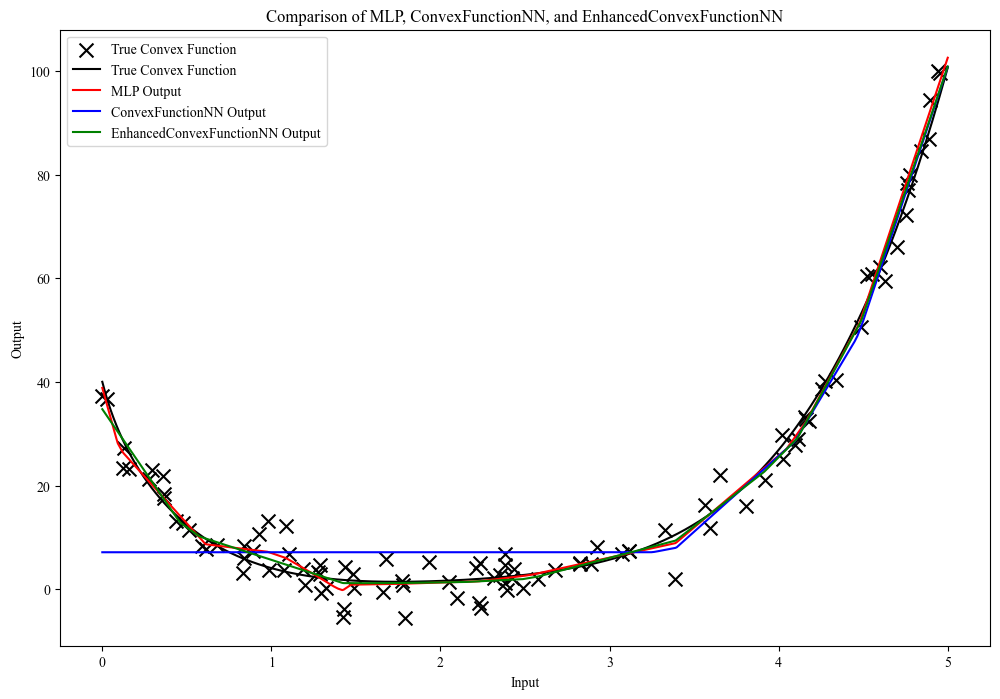

In [149]:
# Testing
x_values_test = np.copy(x_values)
y_values_test = np.copy(y_values)

x_values = np.linspace(0, 5, 600)
y_values = convex_function(x_values)
x_tensor = torch.tensor(x_values.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    y_pred_mlp = mlp_model(x_tensor).numpy()
    y_pred_convex = convex_nn_model(x_tensor)
    if type(y_pred_convex) is tuple:
        y_pred_convex = y_pred_convex[0]
    y_pred_convex = y_pred_convex.numpy()
    y_pred_enhanced_convex = enhanced_convex_nn_model(x_tensor).numpy()

plt.figure(figsize=(12, 8))
plt.scatter(x_values_test, y_values_test, label='True Convex Function', color='black', marker='x', s=100)
plt.plot(x_values, y_values, label='True Convex Function', color='black')
plt.plot(x_values, y_pred_mlp, label='MLP Output', color='red')
plt.plot(x_values, y_pred_convex, label='ConvexFunctionNN Output', color='blue')
plt.plot(x_values, y_pred_enhanced_convex, label='EnhancedConvexFunctionNN Output', color='green')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Comparison of MLP, ConvexFunctionNN, and EnhancedConvexFunctionNN')
plt.legend()
plt.show()


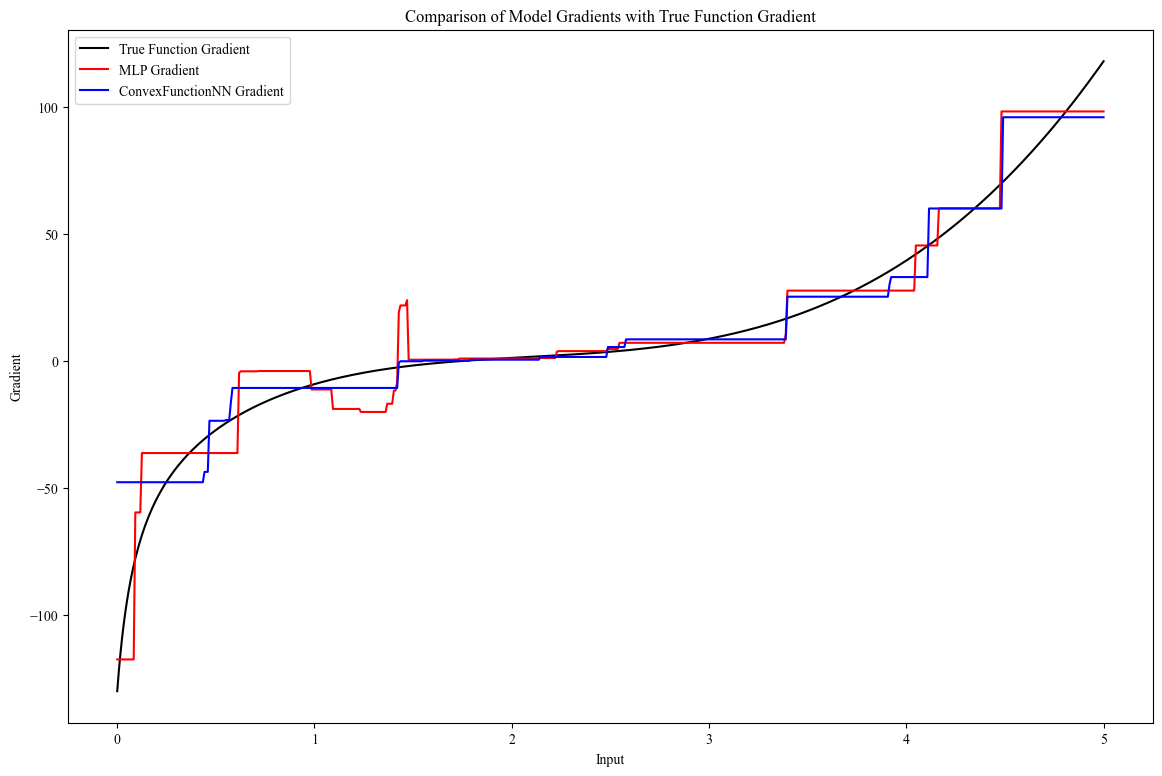

In [150]:
# Function to compute the gradients of model outputs with respect to inputs
def compute_model_gradient(model, inputs):
    inputs.requires_grad_(True)
    outputs = model(inputs)
    outputs.backward(torch.ones_like(outputs))
    return inputs.grad.detach().numpy()

# Correcting the implementation for gradient computation
def compute_model_gradient_corrected(model, inputs):
    # Detach to ensure we don't affect the model weights
    inputs = inputs.detach().clone()
    inputs.requires_grad_(True)
    
    outputs = model(inputs)
    # Need to create a gradient for each output for backward
    grad_outputs = torch.ones_like(outputs)
    outputs.backward(grad_outputs)
    
    return inputs.grad.detach().numpy()

# Compute the gradient of the true convex function
true_function_gradient = convex_function_derivative(x_values)

# Recompute the gradients for the MLP and ConvexFunctionNN models
gradient_mlp = compute_model_gradient_corrected(mlp_model, x_tensor)
gradient_convex_nn = compute_model_gradient_corrected(enhanced_convex_nn_model, x_tensor)

# Plotting the gradients
plt.figure(figsize=(14, 9))
plt.plot(x_values, true_function_gradient, label='True Function Gradient', color='black')
plt.plot(x_values, gradient_mlp.flatten(), label='MLP Gradient', color='red')
plt.plot(x_values, gradient_convex_nn.flatten(), label='ConvexFunctionNN Gradient', color='blue')
plt.xlabel('Input')
plt.ylabel('Gradient')
plt.title('Comparison of Model Gradients with True Function Gradient')
plt.legend()
plt.show()
